<b><font size="5">Intro</font><n></n></b>

In this notebook I will describe my solution of "University of Liverpool - Ion Switching"
This notebook was made by me and my mate - [Andriy Samoshin](https://www.kaggle.com/mrmorj****). We're students of 2nd year KPI, IASA (located in Kyiv, Ukraine)

# Preprocessing/Feature Engineering
<b><font size="4">Importing libraries</font></b>

In [ ]:
from scipy import signal
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import numpy as np
import pandas as pd
import time
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import losses, models, optimizers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

!pip install catboost==0.23.1 -q
seed = 1337

random.seed(seed)
np.random.seed(seed)

<b><font size="4">Reading Train Data</font><n></n></b>

In this kernel I'm using already cleaned data without drift, so I won't pay attention on the preprocessing. You can check it in discussions.

In [ ]:
train = pd.read_csv('../input/data-without-drift/train_clean.csv')
target = train['open_channels']

train.head()

Then let's add some statistical and physical functions:
1. **calc_gradients**: This function calculate gradients for a pandas series. Returns the same number of samples
2. **calc_low_pass**: applies low pass filters to the signal. Left delayed and no delayed. 
3. **calc_high_pass**: applies high pass filters to the signal. Left delayed and no delayed
4. **calc_roll_stats**: calculates rolling stats like mean, std, min, max, quantiles... The number of windows, and specifically the functions themselves were chosen empirically to have gain the best performance.
6. **create_shift**: creates shifts, we choosed only +-1,2,3 because others did not give a sufficient increase in performance.
7. **calc_ewm**: calculates exponential weighted functions.
8. **add_features**: concatenates all calculations together
9. **divide_and_add_features**: dividing the signal in bags of "signal_size".Then normalize the data dividing it by 15.0.
10. **reduce_mem_usage**: apply this function and save quite a lot of memory.

In [ ]:
def calc_gradients(s, n_grads=4):

    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

In [ ]:
def calc_low_pass(s, n_filts=10):

    wns = np.logspace(-2, -0.3, n_filts)
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

In [ ]:
def calc_high_pass(s, n_filts=10):

    wns = np.logspace(-2, -0.3, n_filts)
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

In [ ]:
def calc_roll_stats(s, windows=[3, 10, 50, 100, 500]):

    roll_stats = pd.DataFrame()
    
    for w in windows:
        roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean()
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std()
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min()
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_mean_s_' + str(w)] = s.rolling(window=w, min_periods=1).mean().shift(-w)
        roll_stats['roll_std_s_' + str(w)] = s.rolling(window=w, min_periods=1).std().shift(-w)
        roll_stats['roll_min_s_' + str(w)] = s.rolling(window=w, min_periods=1).min().shift(-w)
        roll_stats['roll_max_s_' + str(w)] = s.rolling(window=w, min_periods=1).max().shift(-w)
        roll_stats['roll_range_s_' + str(w)] = roll_stats['roll_max_s_' + str(w)] - roll_stats['roll_min_s_' + str(w)]
        roll_stats['roll_q25_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.25)
        roll_stats['roll_q75_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.75)
        roll_stats['kurtosis_' + str(w)] = roll_stats.apply(lambda x: pd.Series(x).kurtosis())

    roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

In [ ]:
def create_shift(s, windows=[1, 2, 3]):
    
    cf = pd.DataFrame()

    for w in windows:    
        cf['signal_shift_+' + str(w)] = s.shift(w)
        cf['signal_shift_-' + str(w)] = s.shift(-1*w)

    cf['signal_power'] = s ** 2
    cf = cf.fillna(value=0) 
    
    return cf 

In [ ]:
def calc_ewm(s, windows=[50, 500, 1000]):

    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()

    ewm = ewm.fillna(value=0)
        
    return ewm

In [ ]:
def add_features(s):

    gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    roll_stats = calc_roll_stats(s)
    ewm = calc_ewm(s)
    shift = create_shift(s)
    
    return pd.concat([s, gradients, low_pass, high_pass, roll_stats, ewm, shift], axis=1)

In [ ]:
def divide_and_add_features(s, signal_size=500000):

    s = s/max(s.max(),-s.min())
    ls = []
    for i in tqdm(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig)
        ls.append(sig_featured)

    df = pd.concat(ls, axis=0)

    return df

In [ ]:
def reduce_mem_usage(df, verbose=True):
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
train = divide_and_add_features(train['signal'])
train = reduce_mem_usage(train)

# Modeling
This is the most interesting part as for me. Here I'll show Double Blending, and some interesting insights with Confussion Matrix.
Because of some lack of time we used train test split, I know, it would be much better to use CV, but we did't want to spend ~1 hour for one CV, so we choosed optimal X_train and X_test to have got the same distribution.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=seed)

<b><font size="4">Stacking: Part 1</font><n></n></b>

We used 3 models to make a stack with them: LGBM, Catboost, NN. I will show their structure and Confussion Matrix, but to save time, I will not run them in this kernel.

In [ ]:
def plot_cm(y_true, y_pred, title):
    size = 13
    figsize=(size,size)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

<b><font size="4">NN</font><n></n></b>

We also choose construction of this NN by ourselves, but to improve it, you can try to use more epochs and play with lr and etc.

In [ ]:
def get_class_weight(classes, exp=1):
    hist, _ = np.histogram(classes, bins=np.arange(12)-0.5)
    class_weight = hist.sum()/np.power(hist, exp)
    return class_weight

class_weight = get_class_weight(y_train)
encoder = LabelEncoder()
encoder = encoder.fit(y_train)
y_train = encoder.transform(y_train)
X_test = X_test.to_numpy()
X_train = X_train.to_numpy()
    
model = Sequential()
model.add(Dense(77, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(102, activation="relu"))
model.add(Dense(174, activation="relu"))
model.add(Dense(18, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(11, activation="softmax"))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_crossentropy'])
model.fit(X_train, y_train, batch_size=1024, epochs=35, verbose=1, class_weight=class_weight)

preds=model.predict(X_test)

cnn_preds=[]
for j in range(preds.shape[0]):
    cnn_preds.append(np.argmax(preds[j]))

In [ ]:
plot_cm(y_test, cnn_preds, "NN")

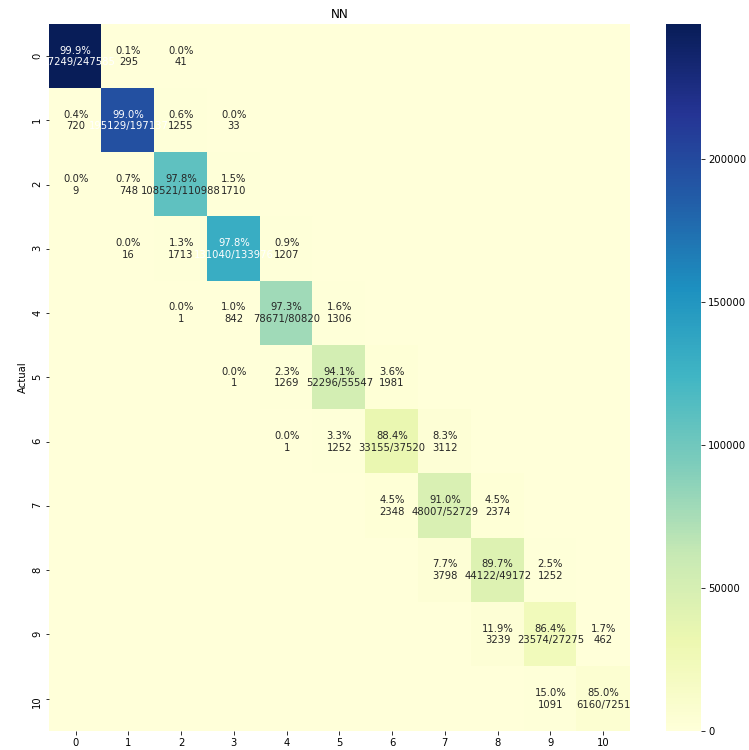

<b><font size="4">Catboost</font><n></n></b>

In my opinion, it's the most powerful part of this models stack. We couldn't add more parameters to Catboost cause we used GPU to spend less time while training.

In [ ]:
catb = CatBoostClassifier(random_seed=seed, verbose=0,loss_function='MultiClass', iterations=3000, learning_rate=0.07, task_type="GPU")
catb.fit(X_train, y_train)
preds_class = catb.predict(X_test, prediction_type='Class')
preds_real = np.apply_along_axis(lambda x: x[0], 1, preds_class)

In [ ]:
plot_cm(y_test, preds_real, "Catboost")

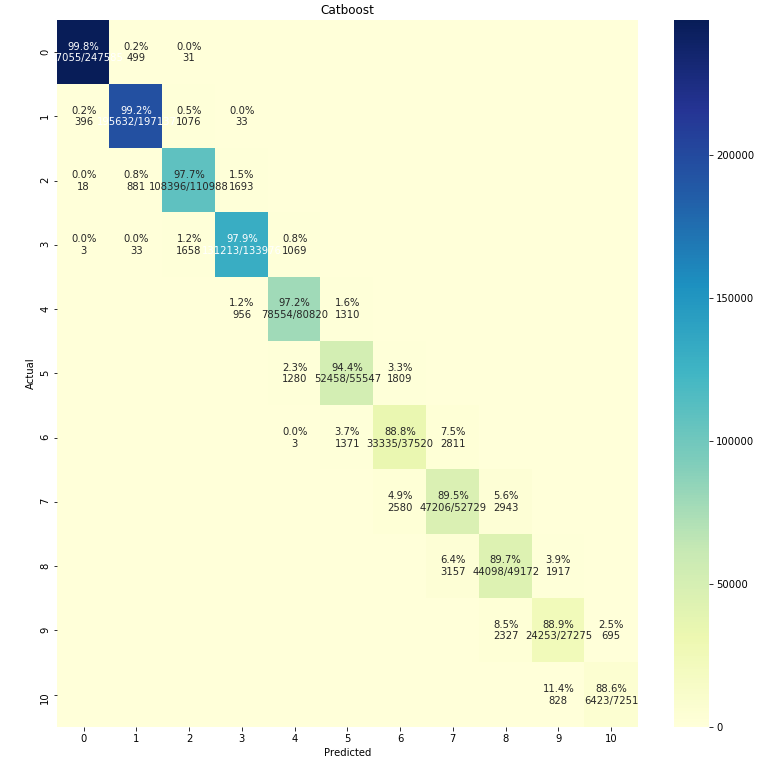

<b><font size="4">LGBM</font><n></n></b>

And the last is LGBM, we din't choose XGBoost, because LGBM is quite fast and hasn't got much difference in comparison with XGB (in performance). Also LGBM was tuned with Optuna. I'll show params of tuned LGBM

In [ ]:
params = {'num_leaves': 475, 
               'max_depth': 91, 
               'max_bin': 230, 
               'min_data_in_leaf': 215, 
               'min_data_in_bin': 173, 
               'min_gain_to_split': 3.99, 
               'lamda_l1': 0.0004829498900910097, 
               'lamda_l2': 1.3150995937706052e-06, 
               'learning_rate': 0.08575524059926458, 
               'metric': 'RMSE', 
               'bagging_fraction': 0.46527611789576895, 
               'feature_fraction': 0.39877736376091427, 
               'bagging_freq': 3}

dataset = lgb.Dataset(X_train,label=y_train)
gbc = lgb.train(params, dataset)
gbc_pred = gbc.predict(X_test).tolist()
gbc_pred = list(map(lambda x: round(x),gbc_pred))

In [ ]:
plot_cm(y_test, gbc_pred, "LGBM")

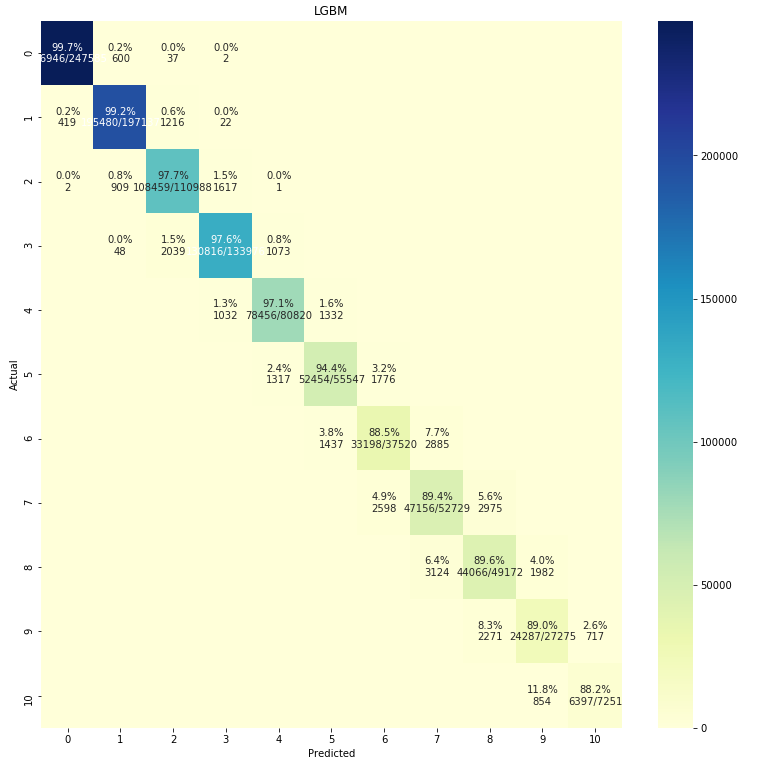

After we've trained these model, we just averaged all results and then round them. It's quite easy method, works as Voting Classifier.

<b><font size="4">Stacking: Part 2</font><n></n></b>

While I was tuning Catboost I've found my model has got slightly better performance on the high labels(6+). So I've decided make "Smart Stacking" on high predictions.
<n> </n>"Smart Stacking" alhoritm:
1. Stack our base models, in my case I averaged them
2. Create a mask on target "target[target>5]" to select only 6+ labels
3. Apply this mask also to train set
4. Predict our masked train set with model for high predictions 
5. Concatenate our masked predictions with old predictions

In [ ]:
catb = CatBoostClassifier(random_seed=seed, verbose=0,loss_function='MultiClass', iterations=3200, learning_rate=0.02,task_type="GPU")
catb.fit(X_train, y_train)
preds_class = catb.predict(X_test, prediction_type='Class')
preds_real = np.apply_along_axis(lambda x: x[0], 1, preds_class)

In [ ]:
plot_cm(y_test, preds_real, "Catboost high")

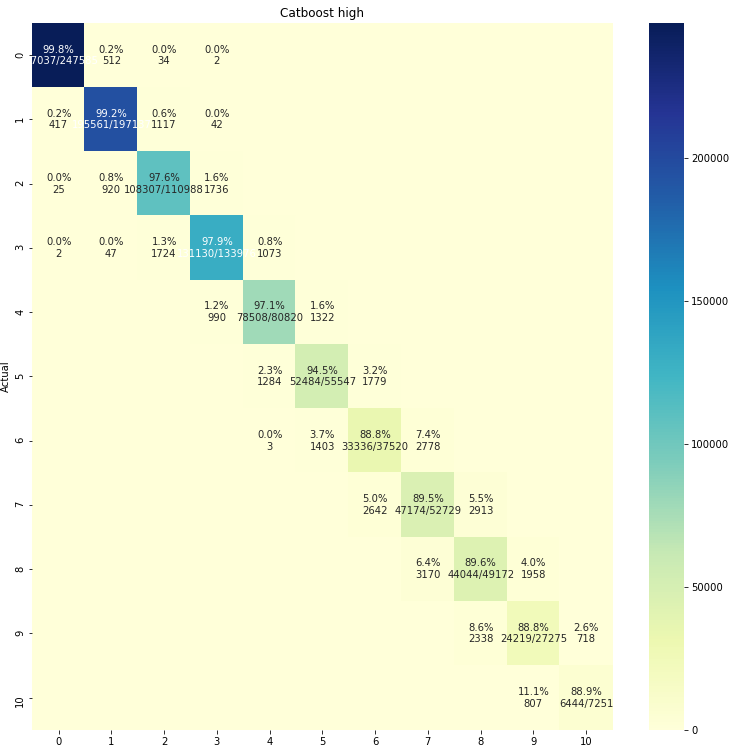

<b><font size="4">Summary</font><n></n></b>

In this kernel main idea was to show my own method of stacking, very powerful tool as Catboost (cause I really can't understand why people doesn't use it as often as XGBoost or LGBM). Also sometimes it's useful to make EDA, which shows you not only plots and will give you clues to the for better solution.
So if this kernel brings you some new information please upvote it! Write your comments because I'm only studying and it'd be pleasant for me to hear some advices from you.